In [16]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read in raw data

In [17]:
rawdata = open("/media/bigger/hiranumn/torsion_data/vall.jul19.2011").readlines()

In [18]:
count = 0
curprot = ""
proteins = []
AAs = []
Phis = []
Psis = []
for i in rawdata:
    if len(i)>2 and i[:2]=="#p":
        header = i.strip().split(" ")
        print "header size:", len(header)
    elif i[0] != "#":
        line = i.strip().split()
        assert len(line) == len(header)
        if line[0] != curprot:
            if count != 0:
                proteins.append([curprot, AAs, Phis, Psis])
            count += 1
            curprot = line[0]
            AAs = [line[1]]
            Phis = [float(line[14])]
            Psis = [float(line[15])]
        else:
            AAs.append(line[1])
            Phis.append(float(line[14]))
            Psis.append(float(line[15]))
proteins.append([curprot, AAs, Phis, Psis])

header size: 61


In [19]:
print len(proteins)

16800


# process

In [20]:
class protein:
    
    def __init__(self, inputs):
        name, AAs, Phis, Psis = inputs
        self.name = name
        self.AAs = AAs
        self.Phis = Phis
        self.Psis = Psis
        self.maps = maps = {'A': 0, 'C': 1, 'E': 2, 'D': 3, 'G': 4, 'F': 5, 'I': 6, 'H': 7, 'K': 8, 'M': 9, 'L': 10, 'N': 11, 'Q': 12, 'P': 13, 'S': 14, 'R': 15, 'T': 16, 'W': 17, 'V': 18, 'Y': 19}
    
    def generate_data(self, window=15):
        # make AAs one hot encoded
        temp_oheAAs = np.zeros((20, len(self.AAs)))
        
        # digitize (bin) output angles
        out_phis = np.zeros((32, len(self.Phis)))
        out_psis = np.zeros((32, len(self.Psis)))
        digitized_phis = np.digitize(np.array(self.Phis), np.arange(-180, 181, 11.26))
        digitized_psis = np.digitize(np.array(self.Psis), np.arange(-180, 181, 11.26))
        
        # Fill them in.
        for i in range(len(self.AAs)):
            temp_oheAAs[self.maps[self.AAs[i]],i] = 1
            out_phis[digitized_phis[i]-1, i] = 1
            out_psis[digitized_psis[i]-1, i] = 1
        
        windowed_AAs = []
        windowed_phis = []
        windowed_psis = []
        
        # Window them
        for i in range(0, len(self.AAs)-window):
            windowed_AAs.append(temp_oheAAs[:, i:i+window])
            windowed_phis.append(out_phis[:, i:i+window])
            windowed_psis.append(out_psis[:, i:i+window])
        
        return np.array(windowed_AAs), np.array(windowed_phis), np.array(windowed_psis)
        

In [21]:
AAs = []
Phis = []
Psis = []

count = 0
for prot in proteins[10000:]:
    p = protein(prot)
    out = p.generate_data()
    if len(p.AAs) > 15:
        AAs.append(out[0])
        Phis.append(out[1])
        Psis.append(out[2])
    count += 1
    
AAs = np.concatenate(AAs)
Phis = np.concatenate(Phis)
Psis = np.concatenate(Psis)

In [22]:
AAs.shape, Phis.shape, Psis.shape

((1568999, 20, 15), (1568999, 32, 15), (1568999, 32, 15))

In [23]:
AAs = np.transpose(AAs, [0,2,1])
Phis = np.transpose(Phis, [0,2,1])
Psis = np.transpose(Psis, [0,2,1])

In [24]:
np.save("/media/bigger/hiranumn/torsion_data/AAs_test.npy", AAs)
np.save("/media/bigger/hiranumn/torsion_data/Phis_test.npy", Phis)
np.save("/media/bigger/hiranumn/torsion_data/Psis_test.npy", Psis)

# Plot for fun

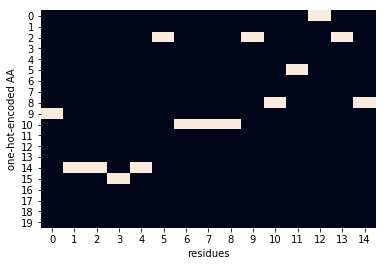

In [26]:
plt.figure()
sns.heatmap(out[0][0], cbar=False)
plt.ylabel('one-hot-encoded AA')
plt.xlabel('residues')
plt.show()

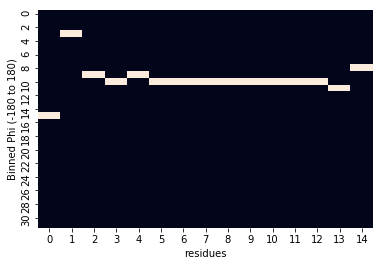

In [27]:
plt.figure()
sns.heatmap(out[1][0], cbar=False)
plt.ylabel('Binned Phi (-180 to 180)')
plt.xlabel('residues')
plt.show()

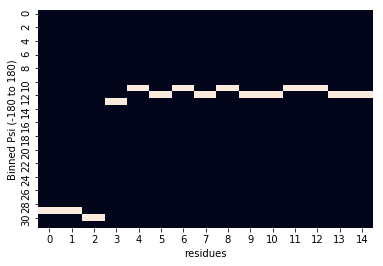

In [28]:
plt.figure()
sns.heatmap(out[2][0], cbar=False)
plt.ylabel('Binned Psi (-180 to 180)')
plt.xlabel('residues')
plt.show()

In [30]:
p.AAs[:15]

['M', 'S', 'S', 'R', 'S', 'E', 'L', 'L', 'L', 'E', 'K', 'F', 'A', 'E', 'K']

In [33]:
print p.Phis[:15]

[0.0, -144.978, -68.067, -61.263, -68.657, -64.923, -65.001, -61.559, -61.287, -63.647, -63.009, -57.111, -59.457, -53.822, -79.844]
